# Majoranas

## Aims of this notebook:

### Part 1
* Define and discretize the Majorana Hamiltonian in a superconductor
* Study the how the ingredients affect the topology of the bandstructure, mainly $\mu$, $\Delta$, $B_{x}$ and $\alpha$

### Part 2
* Define the 1D superconducting lattice
* Attach semiconducting leads (simple, just remove the superconductivity term from Hamiltonian)

### Part 3
* Conductance plots
* Plot Wavefunction/ LDOS: see it the wavefunction differs when we reduce the chain length

### Part 4
* Perturbation: introduce a disorder term in the Hamiltonian

### Part 5
* Benchmark against experiment

Note: To run this notebook, you need to install [Kwant](https://kwant-project.org/) dependencies.




In [1]:
import numpy as np
from matplotlib import pyplot
import kwant
import kwant.continuum
import matplotlib.pyplot as plt

import ipywidgets
from tqdm.notebook import tqdm

pi = np.pi

sigma_0 = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

# Useful operators
phs = np.kron(sigma_y, sigma_y)
trs = np.kron(sigma_y, sigma_0)
eh = -np.kron(sigma_0, sigma_z) # Charge conservation, only if Delta = 0

/opt/anaconda3/lib/python3.11/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


### Symmetries

> `phs = np.kron(sigma_y, sigma_y)` represents particle-hole symmetry. This transformation reflects the creation of a hole state and annihilation of an electron state, vice versa. It transforms an electron with energy E to a hole with energy -E. 

> `eh = -np.kron(sigma_0, sigma_z)` represents electron-hole symmetry. Symmetry in the energy spectrum of the system, for every electron energy E, there is a hole with energy -E

In [2]:
def interact(function, **params):
    params_spec = {
        key: ipywidgets.FloatText(value = value, step = 0.05)
        for key, value in params.items()
    }
    return ipywidgets.interactive(function, **params_spec)

### Defining the system

* We can define a system by simple inputing a string, and the constants in the string can be varied later

In [3]:
majorana_hamiltonian = """
(k_x**2/2 - mu)*kron(sigma_0, sigma_z)
+ alpha*k_x*kron(sigma_y, sigma_z)
+ Delta*kron(sigma_0, sigma_x)
+ B_x*kron(sigma_x, sigma_0)
"""

## A helper function for converting strings like this into evaluable expressions.
h_cont = kwant.continuum.lambdify(majorana_hamiltonian)

In [4]:
momenta = np.linspace(-4, 4, 100)

def plot_spectrum(**params):
    kwant.plotter.spectrum(h_cont, ('k_x', momenta), params = params)

interact(
    plot_spectrum,
    B_x = 0,
    mu = 1,
    alpha = 0.5,
    Delta = 0,
)

interactive(children=(FloatText(value=0.0, description='B_x', step=0.05), FloatText(value=1.0, description='mu…

* We need to get a tight-binding Hamiltonian from the continuum Hamiltonian.

In [12]:
wire_template = kwant.continuum.discretize(majorana_hamiltonian)
infinite_wire = kwant.wraparound.wraparound(wire_template).finalized()

In [13]:
finite_wire = kwant.Builder()

def interval_shape(x_min, x_max):
    def shape(site):
        return x_min <= site.pos[0] < x_max
        
    return shape

finite_wire.fill(wire_template, shape = interval_shape(x_min = 0, x_max = 20), start = [10])

finite_wire = finite_wire.finalized()

def spectrum_finite(**params):
    kwant.plotter.spectrum(
        finite_wire,
        params = params,
        x = ('B_x', np.linspace(0, 1)),
        show = False
    )
    pyplot.ylim(-0.5, 0.5)

interact(
    spectrum_finite,
    B_x = 0,
    mu = 0.3,
    alpha = 0.3,
    Delta = 0.3,
)

interactive(children=(FloatText(value=0.0, description='B_x', step=0.05), FloatText(value=0.3, description='mu…

In [14]:
def spectrum_discrete(**params):
    kwant.plotter.spectrum(
        infinite_wire,
        ('k_x', np.linspace(-np.pi/2, np.pi/2, 1000)),
        params = params,
    )
interact(
    spectrum_discrete,
    B_x = 0.4,
    mu = 0,
    alpha = 0.3,
    Delta = 0.1,
)


interactive(children=(FloatText(value=0.4, description='B_x', step=0.05), FloatText(value=0.0, description='mu…

### Kitaev chain

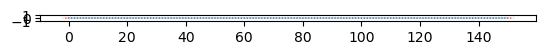

In [15]:
# Define the system
system = kwant.Builder(particle_hole = phs)

# Define a shape function for a 1D chain
def shape_chain(site):
    (x,) = site.pos
    return 0 <= x < 151

# Sweet spot: 150 atoms

# Fill the system with the template based on the defined shape
system.fill(wire_template, shape_chain, (0,))

# Define lead Hamiltonian (without superconductivity)
lead_hamiltonian = """
(k_x**2/2 - mu)*kron(sigma_0, sigma_z)
+ alpha*k_x*kron(sigma_y, sigma_z)
+ B_x*kron(sigma_x, sigma_0)
"""

lead_template = kwant.continuum.discretize(lead_hamiltonian)

# Define a shape function for the leads
def shape_QD(site):
    (x,) = site.pos
    return 0 <= x < 2

# Create and attach leads
lead = kwant.Builder(kwant.TranslationalSymmetry([1]), particle_hole = phs, conservation_law = eh)
lead.fill(lead_template, shape_QD, (0,))
system.attach_lead(lead)
system.attach_lead(lead.reversed())

kwant.plot(system)
kitaev_chain = system.finalized()

### Plot specific sub-matrices of the s-matrix.

> `R_ee = s.transmission((0, 0), (0, 0))` represents the electron-to-electron transmission within the same lead, capturing the probability of an electron passing through the system as an electron without undergoing Andreev reflection or other processes.

> `R_eh = s.transmission((0, 0), (0, 1))` represents the electron-to-hole transmission within the same lead, indicative of Andreev reflection where an incoming electron is reflected as a hole.

> `R_he = s.transmission((0, 1), (0, 0))` represents the hole-to-electron transmission within the same lead, another form of Andreev reflection.

> `R_hh = s.transmission((0, 1), (0, 1))` would represent hole-to-hole transmission within the same lead, analogous to R_ee but for holes.

* N_electrons is the number of channels in the lead. This value is essential to calculate conductance as it sets the maximum possible conductance when all channels are transmitting.

* R_he is added because it reflects the conversion of holes back into electrons, which is an essential part of the superconducting transport process, particularly if we consider crossed Andreev reflections.

* In the majorana tutorials, they took N_electrons + R_he - R_ee. R_ee is subtracted to account for the reflected electrons when it scatters at the boundary (e.g. the semiconductor - superconductor boundary).

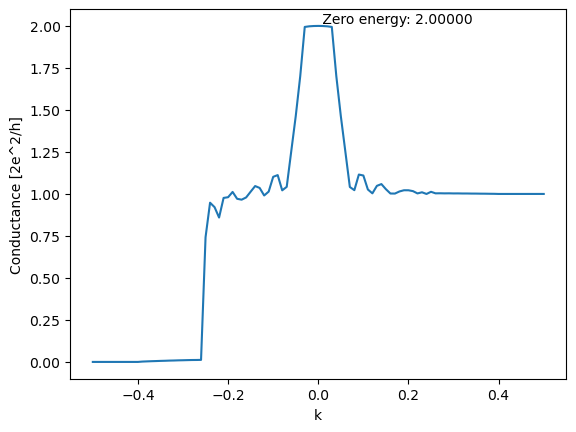

In [16]:
default = dict(
    B_x = 0.4,
    Delta = 0.15,
    mu = 0,
    alpha = 0.12,
)

#default = dict(
#    B_x = 0.5,
#    Delta = 0.4,
#    mu = 0,
#    alpha = 0.2,
#)

energies = np.linspace(-0.5, 0.5, 101)  
transmission = {}

for energy in energies:
    s = kwant.smatrix(kitaev_chain, energy, params={**default})
    N_electrons = len(s.submatrix((0, 0), (0, 0)))
    R_ee = s.transmission((0, 0), (0, 0))
    R_eh = s.transmission((0, 0), (0, 1))
    R_he = s.transmission((0, 1), (0, 0))
    R_hh = s.transmission((0, 1), (0, 1))
    transmission[energy] = N_electrons + R_eh - R_ee

# Plotting the transmission as a function of energy
plt.figure()
plt.plot(energies, transmission.values())
plt.xlabel('k')
plt.ylabel('Conductance [2e^2/h]')

# Label the value at zero energy
zero_energy_conductance = transmission[0]
plt.text(0, zero_energy_conductance, f' Zero energy: {zero_energy_conductance:.5f}', ha='left', va='bottom')
plt.show()


### Majorana phase diagram

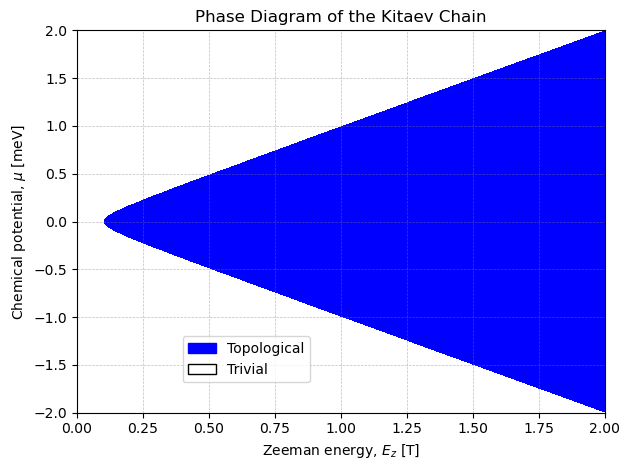

In [17]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

default1 = dict(
    Delta = 0.1,
    alpha = 0.2,
)

def topological_check(mu, B_x, Delta):
    if B_x**2 > mu**2 + Delta**2:
        return 1
    else:
        return 0

mu_values = np.linspace(-2, 2, 1000)
B_values = np.linspace(0, 2, 1000)
phase_map = np.zeros((len(B_values), len(mu_values)))

for i, B_x in enumerate(B_values):
    for j, mu in enumerate(mu_values):
        phase_map[j, i] = topological_check(mu = mu, B_x = B_x, Delta = default1['Delta'])


cmap = ListedColormap(['white', 'blue'])

plt.imshow(phase_map, extent = (B_values.min(), B_values.max(), mu_values.min(), mu_values.max()), origin = 'lower', aspect = 'auto', cmap = cmap)
plt.xlabel('Zeeman energy, $E_z$ [T]')
plt.ylabel('Chemical potential, $\mu$ [meV]')
plt.title('Phase Diagram of the Kitaev Chain')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
legend_handles = [Patch(facecolor='blue', edgecolor='blue', label='Topological'),
                  Patch(facecolor='white', edgecolor='black', label='Trivial')]
plt.legend(handles=legend_handles, bbox_to_anchor=(0.2, 0.2), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


### Plot the wavefunction

* `wave_function(0)` retrieves the wave functions at a specified energy for all sites connected to the first lead (index `0` indicates the first lead in `kwant`'s lead indexing).
* The `[0]` following `wave_function(0)` selects the first scattering state from the potentially multiple states returned by `kwant.wave_function` for the specified energy.

* **Lead Specification**: `(0)` specifies scattering states incoming from the system's first lead.
* **State Selection**: `[0]` selects the first scattering state among those available for the energy in question.

Notes: we should probably sum up all the wavefunction contributions and plot them, not just the first scattering state.


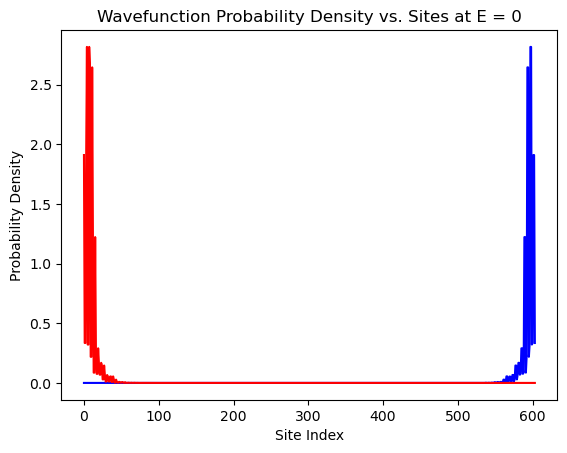

In [18]:
default = dict(
    B_x = 0.5,
    Delta = 0.4,
    mu = 0,
    alpha = 0.2,
)

energy = 0  # Focusing on zero energy for Majorana modes
wave_function = kwant.wave_function(kitaev_chain, energy, params={**default})

# wave_function(0) returns the wavefunctions for all sites for the 0th lead
wf00 = wave_function(0)[0] # Lead 0 in mode 0
wf01 = wave_function(0)[1] # Lead 0 in mode 1
wf10 = wave_function(1)[0] # Lead 1 in mode 0
wf11 = wave_function(1)[1] # Lead 1 in mode 1

# Calculate the probability density of the wavefunction
Amplitude0 = np.abs(wf00)**2 + np.abs(wf01)**2
Amplitude1 = np.abs(wf10)**2 + np.abs(wf11)**2

# Plotting
plt.figure()
plt.plot(Amplitude0, 'b-')
plt.plot(Amplitude1, 'r-')
plt.xlabel('Site Index')
plt.ylabel('Probability Density')
plt.title('Wavefunction Probability Density vs. Sites at E = 0')
plt.show()

### Perturbations
* Need to re-define the system
* We need to add perturbations and test the robustness of the Zero-Bias Conductance Peak (ZBCP)

In [19]:
majorana_hamiltonian = """
(k_x**2/2 - mu)*kron(sigma_0, sigma_z)
+ alpha*k_x*kron(sigma_y, sigma_z)
+ Delta*kron(sigma_0, sigma_x)
+ B_x*kron(sigma_x, sigma_0)
+ V_per(site, V_0, salt) * kron(sigma_0, sigma_z)
"""

def V_per(site, V_0, salt):
    return V_0 * (kwant.digest.uniform(site.tag, salt) - 0.0038)

In [20]:
wire_template = kwant.continuum.discretize(majorana_hamiltonian)

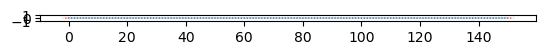

In [21]:
# Define the system
system = kwant.Builder(particle_hole = phs)

# Define a shape function for a 1D chain
def shape_chain(site):
    (x,) = site.pos
    return 0 <= x < 151

# Fill the system with the template based on the defined shape
system.fill(wire_template, shape_chain, (0,))

# Define lead Hamiltonian (without superconductivity)
lead_hamiltonian = """
(k_x**2/2 - mu)*kron(sigma_0, sigma_z)
+ alpha*k_x*kron(sigma_y, sigma_z)
+ B_x*kron(sigma_x, sigma_0)
+ V_per(site, V_0, salt) * kron(sigma_0, sigma_z)
"""

lead_template = kwant.continuum.discretize(lead_hamiltonian)

# Define a shape function for the leads
def shape_QD(site):
    (x,) = site.pos
    return 0 <= x < 2

# Create and attach leads
lead = kwant.Builder(kwant.TranslationalSymmetry([1]), particle_hole = phs, conservation_law = eh)
lead.fill(lead_template, shape_QD, (0,))
system.attach_lead(lead)
system.attach_lead(lead.reversed())

kwant.plot(system)
kitaev_chain = system.finalized()

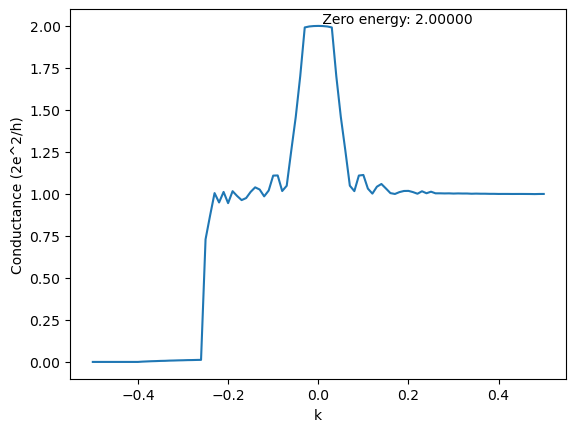

In [22]:
#default = dict(
#    B_x = 0.5,
#    Delta = 0.4,
#    mu = 0,
#    alpha = 0.2,
#)

default = dict(
    B_x = 0.4,
    Delta = 0.15,
    mu = 0,
    alpha = 0.12,
)

energies = np.linspace(-0.5, 0.5, 101)  
transmission = {}


for energy in energies:
    s = kwant.smatrix(kitaev_chain, energy, params = dict(V_per = V_per, V_0 = 0.0038, salt = "minorana", **default))
    N_electrons = len(s.submatrix((0, 0), (0, 0)))
    R_ee = s.transmission((0, 0), (0, 0))
    R_eh = s.transmission((0, 0), (0, 1))
    R_he = s.transmission((0, 1), (0, 0))
    R_hh = s.transmission((0, 1), (0, 1))
    transmission[energy] = N_electrons + R_eh - R_ee

# Plotting the transmission as a function of energy
plt.figure()
plt.plot(energies, transmission.values())
plt.xlabel('k')
plt.ylabel('Conductance (2e^2/h)')
# Label the value at zero energy
zero_energy_conductance = transmission[0]
plt.text(0, zero_energy_conductance, f' Zero energy: {zero_energy_conductance:.5f}', ha='left', va='bottom')
plt.show()